# Notebook 04: SPARC Batch Analysis — Universal Coupling Test

**Objective:** Scale the Rational Taper model from M33 (Notebook 03) to the full
SPARC database (175 galaxies). Test whether the transition radius $R_t$ is
universally coupled to the disk scale length $R_d$ via a constant factor $k$.

## The Universal Formula

$$V_{\text{model}}(R) = V_{\text{bary}}(R) + \frac{\omega R}{1 + \frac{R}{k \cdot R_d}}$$

- **$\omega$ (Vorticity):** Free parameter (varies per galaxy).
- **$k$ (Coupling Constant):** Free parameter — we hope is constant across galaxies.
- **$R_d$ (Disk Scale Length):** Fixed per galaxy from SPARC [3.6] photometry.

**Success Metric:** If the histogram of fitted $k$ values shows a sharp peak
(Gaussian distribution), this implies a universal physical law. A flat/random
distribution suggests the model is just curve-fitting.

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.physics import (
    compute_v_bary,
    fit_omega_tapered_kRd,
    compute_bic,
)
from src.database import get_engine, get_session, query_profiles_as_dataframe
from src.ingest import parse_sparc_metadata_mrt
from src.utils import setup_logger, get_project_root

sns.set_theme(style='whitegrid', font_scale=1.1)
%matplotlib inline

# Mass-to-light ratios (fixed, consistent with Notebooks 01–03)
UPSILON_DISK = 0.5
UPSILON_BULGE = 0.7

# Paths
PROJECT_ROOT = get_project_root()
RESULTS_DIR = PROJECT_ROOT / 'results'
TABLES_DIR = RESULTS_DIR / 'tables'
FIGURES_DIR = RESULTS_DIR / 'figures'
TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')

Project root: C:\Projects\ISM\baryonic-omega-analysis


## 1. Load SPARC Metadata

Parse the master SPARC table (Lelli et al. 2016, Table 1) to get the
**disk scale length** ($R_d$) for each galaxy. This is the critical
parameter that anchors our model to physical observables.

In [2]:
# Parse SPARC metadata MRT file
metadata_path = PROJECT_ROOT / 'data' / 'raw' / 'SPARC_Lelli2016c.mrt'
meta_df = parse_sparc_metadata_mrt(metadata_path)

print(f'SPARC metadata: {len(meta_df)} galaxies')
print(f'Columns: {list(meta_df.columns)}')
print(f'\nR_disk range: {meta_df["r_disk_kpc"].min():.2f} – {meta_df["r_disk_kpc"].max():.2f} kpc')
print(f'Inclination range: {meta_df["inclination"].min():.0f} – {meta_df["inclination"].max():.0f} deg')
print(f'Quality flag distribution:')
print(meta_df['quality_flag'].value_counts().sort_index().to_string())

display(meta_df.head())

2026-02-18 13:57:52 | INFO     | src.ingest | Parsed metadata for 175 galaxies


SPARC metadata: 175 galaxies
Columns: ['galaxy_id', 'hubble_type', 'distance_mpc', 'e_distance_mpc', 'inclination', 'e_inclination', 'luminosity_band_36', 'r_eff_kpc', 'sb_eff', 'r_disk_kpc', 'sb_disk', 'm_hi', 'r_hi_kpc', 'v_flat', 'e_v_flat', 'quality_flag']

R_disk range: 0.18 – 18.76 kpc
Inclination range: 15 – 90 deg
Quality flag distribution:
quality_flag
1    99
2    64
3    12


,galaxy_id,hubble_type,distance_mpc,e_distance_mpc,inclination,e_inclination,luminosity_band_36,r_eff_kpc,sb_eff,r_disk_kpc,sb_disk,m_hi,r_hi_kpc,v_flat,e_v_flat,quality_flag
0,CamB,10,3.36,0.26,65.0,5.0,0.075,1.21,7.89,0.47,66.20,0.012,1.21,0.0,0.0,2
1,D512-2,10,15.20,4.56,56.0,10.0,0.325,2.37,9.22,1.24,93.94,0.081,0.00,0.0,0.0,2
2,D564-8,10,8.79,0.28,63.0,7.0,0.033,0.72,10.11,0.61,21.13,0.029,0.00,0.0,0.0,2
3,D631-7,10,7.72,0.18,59.0,3.0,0.196,1.22,20.93,0.70,115.04,0.290,0.00,57.7,2.7,1
4,DDO064,10,6.80,2.04,60.0,5.0,0.157,1.20,17.41,0.69,151.65,0.211,3.49,46.1,3.9,1


## 2. Quality Cuts

Apply selection criteria to ensure reliable fits:
- **Inclination** $i \geq 30°$ (face-on galaxies have unreliable velocities)
- **Data points** $\geq 10$ per galaxy
- **$R_d > 0$** (need a valid disk scale length)

We do **not** restrict to Q=1 at this stage to maximize sample size;
quality flags are recorded for downstream filtering.

In [3]:
# Build lookup dict from metadata: galaxy_id -> row
meta_lookup = meta_df.set_index('galaxy_id')

# Connect to the database
engine = get_engine()
session = get_session(engine)

# Get all galaxy IDs from the database that also have metadata
from sqlalchemy import text
db_galaxy_ids = pd.read_sql(
    'SELECT DISTINCT galaxy_id FROM radial_profiles', engine
)['galaxy_id'].tolist()

print(f'Galaxies in database: {len(db_galaxy_ids)}')
print(f'Galaxies with SPARC metadata: {len(meta_df)}')

# Find intersection
common = [g for g in db_galaxy_ids if g in meta_lookup.index]
print(f'Galaxies with both profiles and metadata: {len(common)}')

# Apply quality cuts
MIN_INCLINATION = 30.0
MIN_POINTS = 10

candidates = []
excluded_reasons = {'low_inclination': 0, 'few_points': 0, 'no_r_disk': 0}

for gid in common:
    row = meta_lookup.loc[gid]
    inc = row['inclination']
    r_d = row['r_disk_kpc']
    
    if inc < MIN_INCLINATION:
        excluded_reasons['low_inclination'] += 1
        continue
    if r_d <= 0:
        excluded_reasons['no_r_disk'] += 1
        continue
    
    # Check point count
    df = query_profiles_as_dataframe(session, gid)
    if len(df) < MIN_POINTS:
        excluded_reasons['few_points'] += 1
        continue
    
    candidates.append(gid)

print(f'\nAfter quality cuts: {len(candidates)} galaxies')
print(f'Excluded:')
for reason, count in excluded_reasons.items():
    print(f'  {reason}: {count}')

Galaxies in database: 176
Galaxies with SPARC metadata: 175
Galaxies with both profiles and metadata: 175

After quality cuts: 118 galaxies
Excluded:
  low_inclination: 12
  few_points: 45
  no_r_disk: 0


## 3. Batch Fitting Pipeline

For each galaxy that passes quality cuts:
1. Load radial profile from the database
2. Construct $V_{\text{bary}}$ with $\Upsilon_{\text{disk}}=0.5$, $\Upsilon_{\text{bulge}}=0.7$
3. Fit the **$k \cdot R_d$ Rational Taper Model** to solve for $\omega$ and $k$
4. Record fit statistics ($\chi^2_{\text{red}}$, RMSE, BIC)

In [4]:
results = []
failures = []

for i, gid in enumerate(candidates):
    if (i + 1) % 25 == 0 or i == 0:
        print(f'Processing {i + 1}/{len(candidates)}: {gid}...')
    
    try:
        # Load profile
        df = query_profiles_as_dataframe(session, gid)
        radius = df['radius_kpc'].values
        v_obs = df['v_obs'].values
        v_err = df['v_err'].values
        v_gas = df['v_gas'].values
        v_disk = df['v_disk'].values
        v_bulge = df['v_bulge'].values
        
        # Compute V_bary
        v_bary = compute_v_bary(
            v_gas, v_disk, v_bulge,
            upsilon_disk=UPSILON_DISK,
            upsilon_bulge=UPSILON_BULGE,
        )
        
        # Get R_d from metadata
        r_d = float(meta_lookup.loc[gid, 'r_disk_kpc'])
        
        # Fit the k*R_d rational taper model
        fit = fit_omega_tapered_kRd(
            radius, v_obs, v_err, v_bary,
            r_d=r_d,
            galaxy_id=gid,
            upsilon_disk=UPSILON_DISK,
            upsilon_bulge=UPSILON_BULGE,
        )
        
        # Get metadata for this galaxy
        meta_row = meta_lookup.loc[gid]
        
        # Compute BIC (2 free parameters)
        bic = compute_bic(fit.n_points, 2, fit.chi_squared)
        
        results.append({
            'Galaxy_ID': gid,
            'Omega': fit.omega_value,
            'Omega_err': fit.omega_uncertainty,
            'k_coupling': fit.k_value,
            'k_err': fit.k_uncertainty,
            'R_d_kpc': r_d,
            'R_t_kpc': fit.rt_value,
            'V_sat_km_s': fit.omega_value * fit.rt_value,
            'RMSE': fit.residuals_rmse,
            'Chi2_red': fit.reduced_chi_squared,
            'BIC': bic,
            'n_points': fit.n_points,
            'converged': fit.converged,
            'flag_v_obs_lt_v_bary': fit.flag_v_obs_lt_v_bary,
            'inclination': float(meta_row['inclination']),
            'quality_flag': int(meta_row['quality_flag']),
            'hubble_type': int(meta_row['hubble_type']),
            'luminosity_1e9_Lsun': float(meta_row['luminosity_band_36']),
            'v_flat': float(meta_row['v_flat']),
            'distance_mpc': float(meta_row['distance_mpc']),
        })
    except Exception as e:
        failures.append({'Galaxy_ID': gid, 'error': str(e)})

session.close()

# Build results DataFrame
results_df = pd.DataFrame(results)
failures_df = pd.DataFrame(failures)

print(f'\n{"=" * 60}')
print(f'Batch fitting complete.')
print(f'  Attempted: {len(candidates)}')
print(f'  Succeeded: {len(results_df)}')
print(f'  Failed (exception): {len(failures_df)}')

# Separate converged vs not converged
converged_df = results_df[results_df['converged'] == True].copy()
nonconverged_df = results_df[results_df['converged'] == False].copy()
print(f'  Converged: {len(converged_df)}')
print(f'  Did not converge: {len(nonconverged_df)}')
print(f'  Convergence rate: {len(converged_df)/len(results_df)*100:.1f}%')
print(f'{"=" * 60}')

2026-02-18 13:57:52 | INFO     | src.physics | D631-7 [k*R_d taper]: omega=7.9175 +/- 0.7871  k=20.0000 +/- 8.2016  R_t=14.0000  chi2_r=4.46  RMSE=4.30
2026-02-18 13:57:52 | INFO     | src.physics | DDO064 [k*R_d taper]: omega=25.7140 +/- 9.8822  k=2.1830 +/- 1.5927  R_t=1.5063  chi2_r=0.32  RMSE=2.61
2026-02-18 13:57:52 | INFO     | src.physics | DDO154 [k*R_d taper]: omega=15.5247 +/- 0.5531  k=8.7840 +/- 0.5943  R_t=3.2501  chi2_r=3.38  RMSE=1.51
2026-02-18 13:57:52 | INFO     | src.physics | DDO161 [k*R_d taper]: omega=4.7457 +/- 0.2744  k=15.3731 +/- 2.4435  R_t=18.7552  chi2_r=0.46  RMSE=1.64


Processing 1/118: D631-7...


2026-02-18 13:57:52 | INFO     | src.physics | DDO168 [k*R_d taper]: omega=9.7946 +/- 0.9009  k=20.0000 +/- 15.5864  R_t=20.4000  chi2_r=6.50  RMSE=3.64
2026-02-18 13:57:52 | INFO     | src.physics | ESO079-G014 [k*R_d taper]: omega=13.7299 +/- 1.4291  k=1.8314 +/- 0.3246  R_t=9.3033  chi2_r=2.27  RMSE=7.86
2026-02-18 13:57:52 | INFO     | src.physics | ESO116-G012 [k*R_d taper]: omega=19.3993 +/- 1.6702  k=3.4630 +/- 0.5279  R_t=5.2291  chi2_r=1.20  RMSE=3.02
2026-02-18 13:57:52 | INFO     | src.physics | ESO563-G021 [k*R_d taper]: omega=19.1319 +/- 0.8004  k=1.9706 +/- 0.1332  R_t=10.7397  chi2_r=12.94  RMSE=20.55
2026-02-18 13:57:52 | INFO     | src.physics | F568-3 [k*R_d taper]: omega=11.7574 +/- 1.3708  k=1.8016 +/- 0.4661  R_t=8.9899  chi2_r=1.65  RMSE=7.70
2026-02-18 13:57:52 | INFO     | src.physics | F568-V1 [k*R_d taper]: omega=66.7036 +/- 25.4538  k=0.4681 +/- 0.2266  R_t=1.3342  chi2_r=0.26  RMSE=7.33
2026-02-18 13:57:52 | INFO     | src.physics | F571-8 [k*R_d taper]: ome

Processing 25/118: NGC0891...


2026-02-18 13:57:52 | INFO     | src.physics | NGC2976 [k*R_d taper]: omega=13.5176 +/- 2.0938  k=12.1903 +/- 18.2607  R_t=12.3122  chi2_r=0.35  RMSE=1.97
2026-02-18 13:57:52 | INFO     | src.physics | NGC2998 [k*R_d taper]: omega=12.0898 +/- 1.8980  k=1.5053 +/- 0.3130  R_t=9.3327  chi2_r=3.80  RMSE=27.25
2026-02-18 13:57:52 | INFO     | src.physics | NGC3109 [k*R_d taper]: omega=12.7592 +/- 0.7054  k=5.7025 +/- 0.9564  R_t=8.8959  chi2_r=0.29  RMSE=1.08
2026-02-18 13:57:52 | INFO     | src.physics | NGC3198 [k*R_d taper]: omega=11.7903 +/- 0.2835  k=2.7594 +/- 0.0978  R_t=8.6645  chi2_r=1.36  RMSE=6.44
2026-02-18 13:57:52 | INFO     | src.physics | NGC3521 [k*R_d taper]: omega=7.1828 +/- 0.8522  k=20.0000 +/- 11.4611  R_t=48.0000  chi2_r=0.47  RMSE=6.10
2026-02-18 13:57:52 | INFO     | src.physics | NGC3726 [k*R_d taper]: omega=3.3754 +/- 0.4540  k=20.0000 +/- 12.5192  R_t=68.0000  chi2_r=2.17  RMSE=9.04
2026-02-18 13:57:52 | INFO     | src.physics | NGC3741 [k*R_d taper]: omega=17.5

Processing 50/118: NGC4088...


2026-02-18 13:57:52 | INFO     | src.physics | NGC5985 [k*R_d taper]: omega=200.0000 +/- 42.2793  k=0.1013 +/- 0.0224  R_t=0.7104  chi2_r=3.78  RMSE=10.01
2026-02-18 13:57:52 | INFO     | src.physics | NGC6015 [k*R_d taper]: omega=36.4286 +/- 1.4337  k=0.9431 +/- 0.0492  R_t=2.1691  chi2_r=11.19  RMSE=11.04
2026-02-18 13:57:52 | INFO     | src.physics | NGC6195 [k*R_d taper]: omega=2.0195 +/- 0.2467  k=20.0000 +/- 25.9841  R_t=278.8000  chi2_r=2.54  RMSE=9.70
2026-02-18 13:57:52 | INFO     | src.physics | NGC6503 [k*R_d taper]: omega=13.5549 +/- 0.4964  k=3.2294 +/- 0.1828  R_t=6.9755  chi2_r=3.16  RMSE=4.54
2026-02-18 13:57:52 | INFO     | src.physics | NGC6674 [k*R_d taper]: omega=14.5416 +/- 1.1479  k=1.7581 +/- 0.1727  R_t=10.6189  chi2_r=12.04  RMSE=16.07
2026-02-18 13:57:52 | INFO     | src.physics | NGC6946 [k*R_d taper]: omega=4.9983 +/- 0.2160  k=17.6409 +/- 4.0630  R_t=43.0439  chi2_r=2.12  RMSE=7.85
2026-02-18 13:57:52 | INFO     | src.physics | NGC7331 [k*R_d taper]: omega=

Processing 75/118: UGC02885...


2026-02-18 13:57:52 | INFO     | src.physics | UGC05716 [k*R_d taper]: omega=35.5375 +/- 2.4992  k=1.1963 +/- 0.1050  R_t=1.3638  chi2_r=2.20  RMSE=1.43
2026-02-18 13:57:52 | INFO     | src.physics | UGC05721 [k*R_d taper]: omega=77.4428 +/- 11.1985  k=2.0779 +/- 0.3812  R_t=0.7896  chi2_r=0.89  RMSE=4.36
2026-02-18 13:57:52 | INFO     | src.physics | UGC05750 [k*R_d taper]: omega=9.1004 +/- 2.9058  k=1.8910 +/- 1.1615  R_t=6.5429  chi2_r=0.30  RMSE=4.48
2026-02-18 13:57:52 | INFO     | src.physics | UGC05764 [k*R_d taper]: omega=133.1247 +/- 19.6847  k=0.2429 +/- 0.0415  R_t=0.2842  chi2_r=6.45  RMSE=3.73
2026-02-18 13:57:52 | INFO     | src.physics | UGC05829 [k*R_d taper]: omega=29.1647 +/- 13.0784  k=0.5886 +/- 0.3435  R_t=1.1713  chi2_r=0.09  RMSE=1.36
2026-02-18 13:57:52 | INFO     | src.physics | UGC05986 [k*R_d taper]: omega=23.2375 +/- 1.7074  k=2.8537 +/- 0.3872  R_t=4.7656  chi2_r=1.23  RMSE=4.15
2026-02-18 13:57:52 | INFO     | src.physics | UGC06446 [k*R_d taper]: omega=71

Processing 100/118: UGC07151...


2026-02-18 13:57:53 | INFO     | src.physics | UGC11557 [k*R_d taper]: omega=1.5592 +/- 1.6008  k=20.0000 +/- 159.0883  R_t=55.0000  chi2_r=1.28  RMSE=8.47
2026-02-18 13:57:53 | INFO     | src.physics | UGC11820 [k*R_d taper]: omega=18.9113 +/- 2.4416  k=1.2715 +/- 0.2059  R_t=2.6448  chi2_r=5.02  RMSE=5.61
2026-02-18 13:57:53 | INFO     | src.physics | UGC11914 [k*R_d taper]: omega=58.4630 +/- 4.0996  k=0.5684 +/- 0.0505  R_t=1.3868  chi2_r=5.29  RMSE=9.84
2026-02-18 13:57:53 | INFO     | src.physics | UGC12506 [k*R_d taper]: omega=165.0096 +/- 84.3957  k=0.1000 +/- 0.0532  R_t=0.7380  chi2_r=0.22  RMSE=6.41
2026-02-18 13:57:53 | INFO     | src.physics | UGC12632 [k*R_d taper]: omega=42.2370 +/- 11.4766  k=0.4182 +/- 0.1331  R_t=1.0121  chi2_r=0.55  RMSE=2.66
2026-02-18 13:57:53 | INFO     | src.physics | UGC12732 [k*R_d taper]: omega=33.5916 +/- 5.8768  k=0.8578 +/- 0.1804  R_t=1.6985  chi2_r=0.11  RMSE=1.05
2026-02-18 13:57:53 | INFO     | src.physics | UGCA444 [k*R_d taper]: omega=


Batch fitting complete.
  Attempted: 118
  Succeeded: 118
  Failed (exception): 0
  Converged: 118
  Did not converge: 0
  Convergence rate: 100.0%


In [5]:
# Summary statistics for converged fits
print('Summary Statistics (converged fits only)')
print('=' * 55)
for col in ['Omega', 'k_coupling', 'R_t_kpc', 'V_sat_km_s', 'RMSE', 'Chi2_red']:
    vals = converged_df[col]
    print(f'{col:15s}  median={vals.median():8.2f}  mean={vals.mean():8.2f}  '
          f'std={vals.std():8.2f}  [{vals.min():.2f}, {vals.max():.2f}]')

print(f'\nFailed galaxies:')
if len(failures_df) > 0:
    display(failures_df)
else:
    print('  None')

if len(nonconverged_df) > 0:
    print(f'\nNon-converged galaxies: {nonconverged_df["Galaxy_ID"].tolist()}')

Summary Statistics (converged fits only)
Omega            median=   13.90  mean=   24.23  std=   30.54  [1.56, 200.00]
k_coupling       median=    2.81  mean=    6.14  std=    7.00  [0.10, 20.00]
R_t_kpc          median=    8.78  mean=   21.85  std=   40.29  [0.12, 278.80]
V_sat_km_s       median=  100.03  mean=  136.28  std=  122.40  [3.56, 840.44]
RMSE             median=    5.91  mean=    8.35  std=    7.49  [0.87, 43.74]
Chi2_red         median=    1.47  mean=    5.28  std=   11.16  [0.07, 84.78]

Failed galaxies:
  None


## 4. The "Eureka" Analysis

### Analysis A: Distribution of $k$ (The Coupling Constant)

A sharp, Gaussian peak in $k$ implies a universal physical law.
A flat or random distribution implies overfitting.

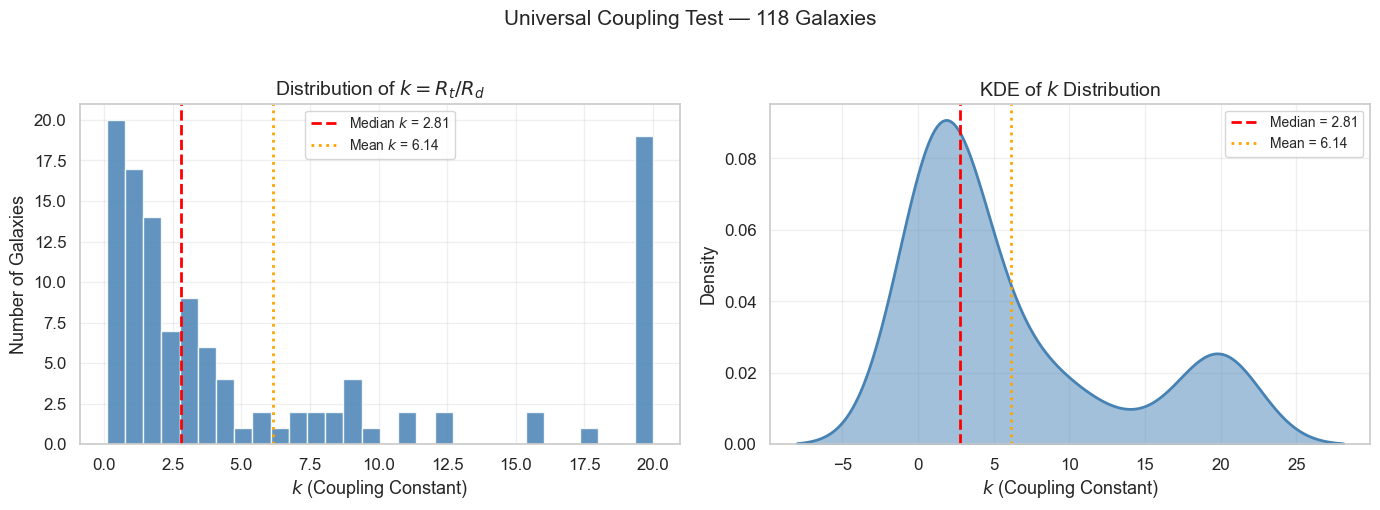

Figure saved: results/figures/k_distribution.png

k statistics (N=118):
  Median: 2.807
  Mean:   6.144
  Std:    6.965
  IQR:    [1.200, 8.774]


In [6]:
# Use only converged fits with reasonable k values for the histogram
k_vals = converged_df['k_coupling'].values
# Remove extreme outliers for visualization (keep within bounds)
k_valid = k_vals[(k_vals > 0.1) & (k_vals < 20.0) & np.isfinite(k_vals)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left panel: Full histogram ---
ax = axes[0]
ax.hist(k_valid, bins=30, color='steelblue', edgecolor='white', alpha=0.85)
ax.axvline(np.median(k_valid), color='red', linewidth=2, linestyle='--',
           label=f'Median $k$ = {np.median(k_valid):.2f}')
ax.axvline(np.mean(k_valid), color='orange', linewidth=2, linestyle=':',
           label=f'Mean $k$ = {np.mean(k_valid):.2f}')

# Mark M33 k value (R_t/R_d from Notebook 03)
if 'M33' in converged_df['Galaxy_ID'].values:
    k_m33 = converged_df.loc[converged_df['Galaxy_ID'] == 'M33', 'k_coupling'].values[0]
    ax.axvline(k_m33, color='green', linewidth=2, linestyle='-',
               label=f'M33: $k$ = {k_m33:.2f}')

ax.set_xlabel('$k$ (Coupling Constant)', fontsize=13)
ax.set_ylabel('Number of Galaxies', fontsize=13)
ax.set_title('Distribution of $k = R_t / R_d$', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# --- Right panel: KDE for shape ---
ax = axes[1]
sns.kdeplot(k_valid, ax=ax, fill=True, color='steelblue', alpha=0.5, linewidth=2)
ax.axvline(np.median(k_valid), color='red', linewidth=2, linestyle='--',
           label=f'Median = {np.median(k_valid):.2f}')
ax.axvline(np.mean(k_valid), color='orange', linewidth=2, linestyle=':',
           label=f'Mean = {np.mean(k_valid):.2f}')
ax.set_xlabel('$k$ (Coupling Constant)', fontsize=13)
ax.set_ylabel('Density', fontsize=13)
ax.set_title('KDE of $k$ Distribution', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle(f'Universal Coupling Test — {len(k_valid)} Galaxies', fontsize=15, y=1.02)
plt.tight_layout()
fig.savefig(
    FIGURES_DIR / 'k_distribution.png',
    dpi=150, bbox_inches='tight',
)
plt.show()
print(f'Figure saved: results/figures/k_distribution.png')
print(f'\nk statistics (N={len(k_valid)}):')
print(f'  Median: {np.median(k_valid):.3f}')
print(f'  Mean:   {np.mean(k_valid):.3f}')
print(f'  Std:    {np.std(k_valid):.3f}')
print(f'  IQR:    [{np.percentile(k_valid, 25):.3f}, {np.percentile(k_valid, 75):.3f}]')

### Analysis B: Scaling Relations

Investigate how $\omega$ correlates with galaxy properties:
- **$\omega$ vs. $V_{\text{flat}}$**: Does vorticity scale with total mass?
- **$\omega$ vs. Luminosity ($L_{[3.6]}$)**: Stellar mass proxy.
- **$\omega$ vs. Surface Brightness ($\Sigma_{\text{disk}}$)**: Does the "dark" effect depend on diffuseness?

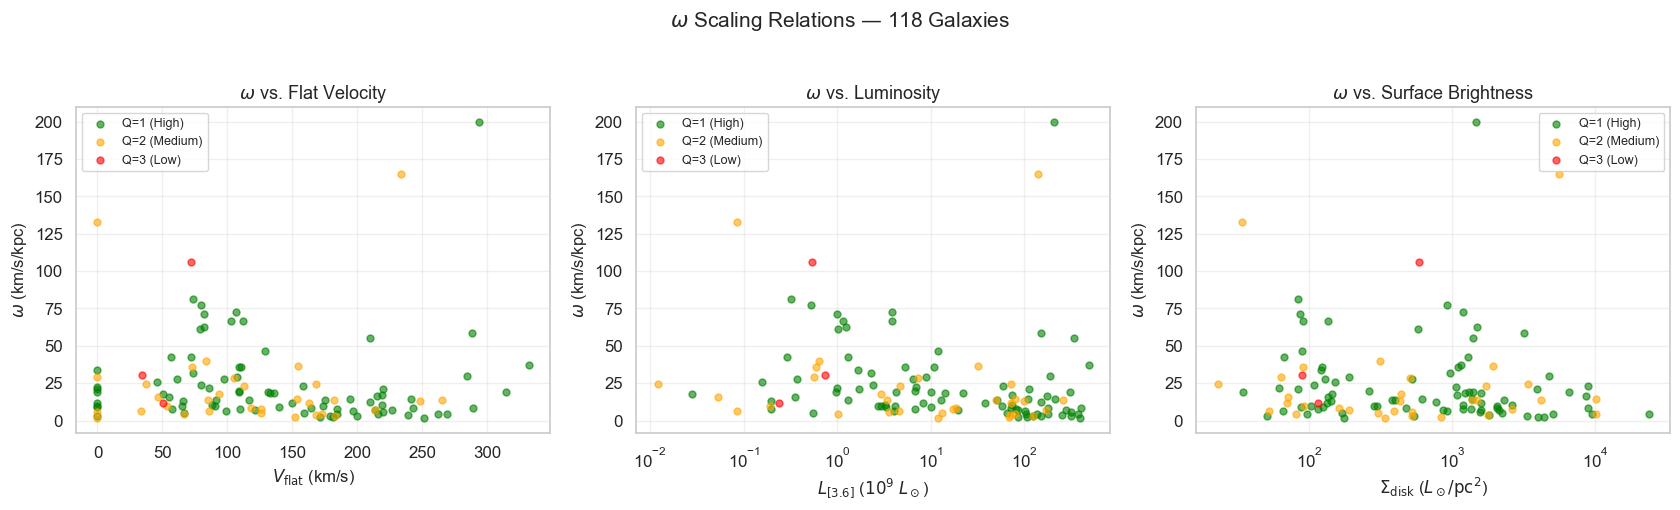

Figure saved: results/figures/omega_scaling.png


In [7]:
# Merge metadata for the scaling relation plots
plot_df = converged_df.copy()

# Compute disk central surface brightness from metadata
# sb_disk is already in meta_lookup (solLum/pc2)
plot_df['sb_disk'] = plot_df['Galaxy_ID'].map(
    lambda g: meta_lookup.loc[g, 'sb_disk'] if g in meta_lookup.index else np.nan
)

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Color by quality flag
q_colors = {1: 'green', 2: 'orange', 3: 'red'}
q_labels = {1: 'Q=1 (High)', 2: 'Q=2 (Medium)', 3: 'Q=3 (Low)'}

# --- Panel 1: omega vs V_flat ---
ax = axes[0]
for q in sorted(plot_df['quality_flag'].unique()):
    mask = plot_df['quality_flag'] == q
    ax.scatter(
        plot_df.loc[mask, 'v_flat'],
        plot_df.loc[mask, 'Omega'],
        c=q_colors.get(q, 'gray'), s=25, alpha=0.6,
        label=q_labels.get(q, f'Q={q}'),
    )
ax.set_xlabel('$V_{\mathrm{flat}}$ (km/s)', fontsize=12)
ax.set_ylabel('$\omega$ (km/s/kpc)', fontsize=12)
ax.set_title('$\omega$ vs. Flat Velocity', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Panel 2: omega vs Luminosity ---
ax = axes[1]
for q in sorted(plot_df['quality_flag'].unique()):
    mask = plot_df['quality_flag'] == q
    lum = plot_df.loc[mask, 'luminosity_1e9_Lsun']
    ax.scatter(
        lum, plot_df.loc[mask, 'Omega'],
        c=q_colors.get(q, 'gray'), s=25, alpha=0.6,
        label=q_labels.get(q, f'Q={q}'),
    )
ax.set_xscale('log')
ax.set_xlabel('$L_{[3.6]}$ ($10^9$ $L_\odot$)', fontsize=12)
ax.set_ylabel('$\omega$ (km/s/kpc)', fontsize=12)
ax.set_title('$\omega$ vs. Luminosity', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Panel 3: omega vs Surface Brightness ---
ax = axes[2]
sb_valid = plot_df[plot_df['sb_disk'] > 0].copy()
for q in sorted(sb_valid['quality_flag'].unique()):
    mask = sb_valid['quality_flag'] == q
    ax.scatter(
        sb_valid.loc[mask, 'sb_disk'],
        sb_valid.loc[mask, 'Omega'],
        c=q_colors.get(q, 'gray'), s=25, alpha=0.6,
        label=q_labels.get(q, f'Q={q}'),
    )
ax.set_xscale('log')
ax.set_xlabel('$\Sigma_{\mathrm{disk}}$ ($L_\odot/\mathrm{pc}^2$)', fontsize=12)
ax.set_ylabel('$\omega$ (km/s/kpc)', fontsize=12)
ax.set_title('$\omega$ vs. Surface Brightness', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.suptitle(f'$\omega$ Scaling Relations — {len(plot_df)} Galaxies', fontsize=15, y=1.02)
plt.tight_layout()
fig.savefig(
    FIGURES_DIR / 'omega_scaling.png',
    dpi=150, bbox_inches='tight',
)
plt.show()
print(f'Figure saved: results/figures/omega_scaling.png')

### Analysis C: $k$ vs. Galaxy Properties

If $k$ is truly universal, it should show **no trend** with galaxy
mass, morphology, or surface brightness.

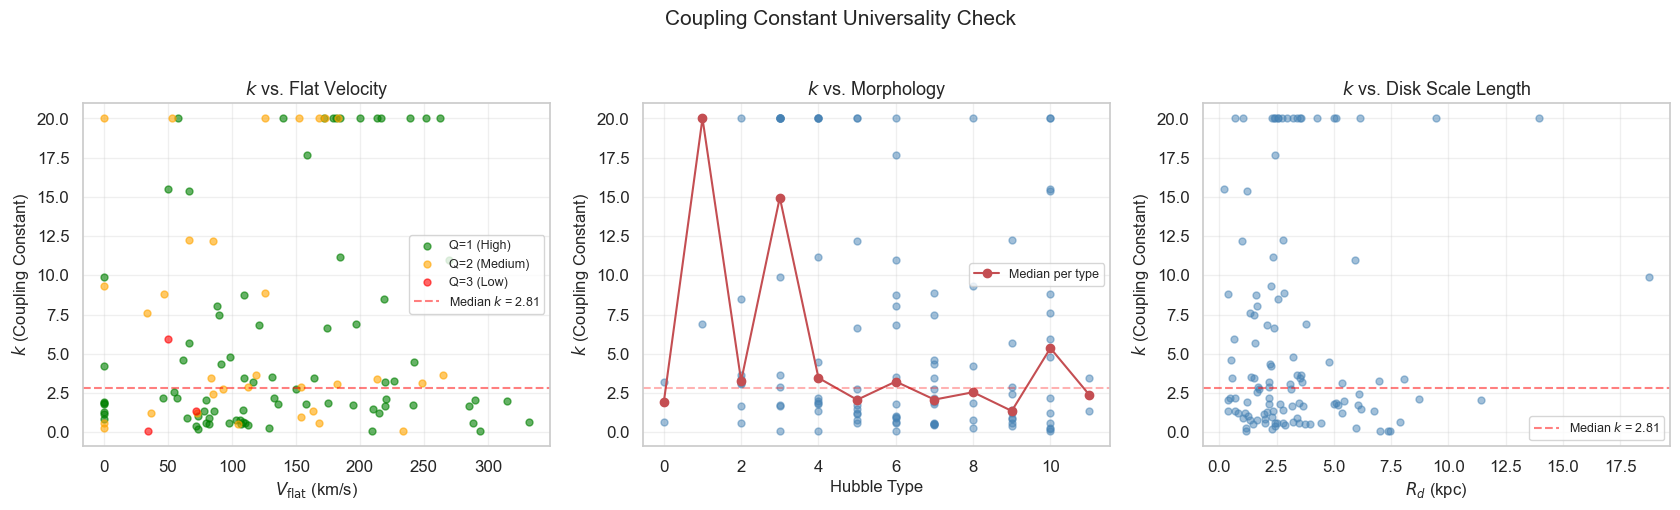

Figure saved: results/figures/k_universality.png


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# --- Panel 1: k vs V_flat (mass proxy) ---
ax = axes[0]
for q in sorted(plot_df['quality_flag'].unique()):
    mask = plot_df['quality_flag'] == q
    ax.scatter(
        plot_df.loc[mask, 'v_flat'],
        plot_df.loc[mask, 'k_coupling'],
        c=q_colors.get(q, 'gray'), s=25, alpha=0.6,
        label=q_labels.get(q, f'Q={q}'),
    )
ax.axhline(np.median(k_valid), color='red', linestyle='--', alpha=0.5,
           label=f'Median $k$ = {np.median(k_valid):.2f}')
ax.set_xlabel('$V_{\mathrm{flat}}$ (km/s)', fontsize=12)
ax.set_ylabel('$k$ (Coupling Constant)', fontsize=12)
ax.set_title('$k$ vs. Flat Velocity', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Panel 2: k vs Hubble type ---
ax = axes[1]
ax.scatter(
    plot_df['hubble_type'], plot_df['k_coupling'],
    c='steelblue', s=25, alpha=0.5,
)
# Boxplot overlay by Hubble type
ht_medians = plot_df.groupby('hubble_type')['k_coupling'].median()
ax.plot(ht_medians.index, ht_medians.values, 'r-o', markersize=6, linewidth=1.5,
        label='Median per type')
ax.axhline(np.median(k_valid), color='red', linestyle='--', alpha=0.3)
ax.set_xlabel('Hubble Type', fontsize=12)
ax.set_ylabel('$k$ (Coupling Constant)', fontsize=12)
ax.set_title('$k$ vs. Morphology', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Panel 3: k vs R_d ---
ax = axes[2]
ax.scatter(
    plot_df['R_d_kpc'], plot_df['k_coupling'],
    c='steelblue', s=25, alpha=0.5,
)
ax.axhline(np.median(k_valid), color='red', linestyle='--', alpha=0.5,
           label=f'Median $k$ = {np.median(k_valid):.2f}')
ax.set_xlabel('$R_d$ (kpc)', fontsize=12)
ax.set_ylabel('$k$ (Coupling Constant)', fontsize=12)
ax.set_title('$k$ vs. Disk Scale Length', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.suptitle(f'Coupling Constant Universality Check', fontsize=15, y=1.02)
plt.tight_layout()
fig.savefig(
    FIGURES_DIR / 'k_universality.png',
    dpi=150, bbox_inches='tight',
)
plt.show()
print(f'Figure saved: results/figures/k_universality.png')

## 5. Fit Quality Overview

Examine the distribution of $\chi^2_{\text{red}}$ and RMSE to assess
how well the rational taper model fits across the sample.

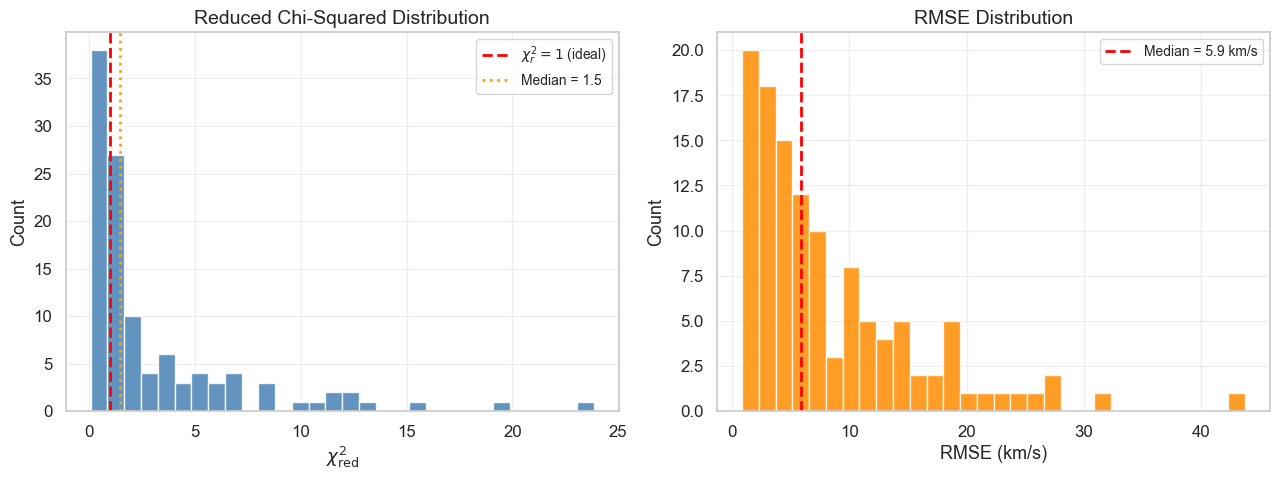


Galaxies with chi2_red < 5: 89/118 (75.4%)
Galaxies with RMSE < 10 km/s: 81/118


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# --- Chi2_red distribution ---
ax = axes[0]
chi2_vals = converged_df['Chi2_red'].values
chi2_clipped = chi2_vals[chi2_vals < np.percentile(chi2_vals, 95)]  # clip for viz
ax.hist(chi2_clipped, bins=30, color='steelblue', edgecolor='white', alpha=0.85)
ax.axvline(1.0, color='red', linewidth=2, linestyle='--', label='$\chi^2_r = 1$ (ideal)')
ax.axvline(np.median(chi2_vals), color='orange', linewidth=2, linestyle=':',
           label=f'Median = {np.median(chi2_vals):.1f}')
ax.set_xlabel('$\chi^2_{\mathrm{red}}$', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Reduced Chi-Squared Distribution', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# --- RMSE distribution ---
ax = axes[1]
rmse_vals = converged_df['RMSE'].values
ax.hist(rmse_vals, bins=30, color='darkorange', edgecolor='white', alpha=0.85)
ax.axvline(np.median(rmse_vals), color='red', linewidth=2, linestyle='--',
           label=f'Median = {np.median(rmse_vals):.1f} km/s')
ax.set_xlabel('RMSE (km/s)', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('RMSE Distribution', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# How many have chi2_red < 5?
good_fits = (chi2_vals < 5).sum()
print(f'\nGalaxies with chi2_red < 5: {good_fits}/{len(chi2_vals)} ({good_fits/len(chi2_vals)*100:.1f}%)')
print(f'Galaxies with RMSE < 10 km/s: {(rmse_vals < 10).sum()}/{len(rmse_vals)}')

## 6. Export Results

In [10]:
# Export the full batch results table
out_path = TABLES_DIR / 'SPARC_tapered_batch_results.csv'
results_df.to_csv(out_path, index=False, float_format='%.6f')
print(f'Saved: {out_path}')
print(f'  {len(results_df)} rows ({len(converged_df)} converged)')

# Show top-10 best fits by chi2_red
print(f'\nTop 10 Best Fits (by chi2_red):')
display(
    converged_df.nsmallest(10, 'Chi2_red')[
        ['Galaxy_ID', 'Omega', 'k_coupling', 'R_d_kpc', 'R_t_kpc',
         'V_sat_km_s', 'Chi2_red', 'RMSE', 'quality_flag']
    ].reset_index(drop=True)
)

Saved: C:\Projects\ISM\baryonic-omega-analysis\results\tables\SPARC_tapered_batch_results.csv
  118 rows (118 converged)

Top 10 Best Fits (by chi2_red):


,Galaxy_ID,Omega,k_coupling,R_d_kpc,R_t_kpc,V_sat_km_s,Chi2_red,RMSE,quality_flag
0,UGC05005,6.142191,4.784056,3.20,15.308978,94.030665,0.067983,2.464613,1
1,UGC05829,29.164724,0.588594,1.99,1.171303,34.160728,0.088882,1.364530,2
2,UGC12732,33.591588,0.857839,1.98,1.698522,57.056055,0.109451,1.054810,1
3,UGC01281,15.751555,2.547856,1.63,4.153006,65.416298,0.110284,1.414524,1
4,UGC07089,5.713273,9.336586,2.26,21.100684,120.553974,0.126235,1.568572,2
5,NGC0100,10.088524,8.062517,1.66,13.383778,135.022570,0.129131,1.453799,1
6,UGC08490,61.182040,1.358696,0.67,0.910326,55.695606,0.150590,1.383383,1
7,NGC1705,105.871181,1.326869,0.39,0.517479,54.786109,0.190056,2.900076,3
8,KK98-251,6.583826,7.607823,1.34,10.194483,67.118707,0.218204,0.869735,2
9,UGC07323,9.533861,4.187681,2.26,9.464159,90.229983,0.218458,1.617857,1


## 7. Session Log

In [11]:
log = setup_logger(
    'nb04_sparc_batch',
    log_file=True,
    clear_logs=True,
)

log.info('=' * 60)
log.info('NOTEBOOK 04 — SPARC BATCH ANALYSIS (UNIVERSAL COUPLING TEST)')
log.info('=' * 60)
log.info('Model: V_bary + omega*R / (1 + R / (k * R_d))')
log.info('Upsilon_disk=%.2f, Upsilon_bulge=%.2f', UPSILON_DISK, UPSILON_BULGE)
log.info('Quality cuts: Inc >= %.0f deg, N_points >= %d, R_d > 0',
         MIN_INCLINATION, MIN_POINTS)
log.info('---')
log.info('Galaxies attempted: %d', len(candidates))
log.info('Converged: %d (%.1f%%)', len(converged_df),
         len(converged_df)/len(results_df)*100 if len(results_df) > 0 else 0)
log.info('Failed (exception): %d', len(failures_df))
log.info('---')
log.info('k coupling: median=%.3f  mean=%.3f  std=%.3f',
         np.median(k_valid), np.mean(k_valid), np.std(k_valid))
log.info('omega: median=%.3f  mean=%.3f',
         converged_df['Omega'].median(), converged_df['Omega'].mean())
log.info('chi2_red: median=%.2f', converged_df['Chi2_red'].median())
log.info('RMSE: median=%.2f km/s', converged_df['RMSE'].median())
log.info('---')
log.info('Exports: SPARC_tapered_batch_results.csv')
log.info('Figures: k_distribution.png, omega_scaling.png, k_universality.png')
log.info('=' * 60)

print('\nLog written to logs/nb04_sparc_batch.log')

2026-02-18 13:57:56 | INFO     | nb04_sparc_batch | ============================================================
2026-02-18 13:57:56 | INFO     | nb04_sparc_batch | NOTEBOOK 04 — SPARC BATCH ANALYSIS (UNIVERSAL COUPLING TEST)
2026-02-18 13:57:56 | INFO     | nb04_sparc_batch | ============================================================
2026-02-18 13:57:56 | INFO     | nb04_sparc_batch | Model: V_bary + omega*R / (1 + R / (k * R_d))
2026-02-18 13:57:56 | INFO     | nb04_sparc_batch | Upsilon_disk=0.50, Upsilon_bulge=0.70
2026-02-18 13:57:56 | INFO     | nb04_sparc_batch | Quality cuts: Inc >= 30 deg, N_points >= 10, R_d > 0
2026-02-18 13:57:56 | INFO     | nb04_sparc_batch | ---
2026-02-18 13:57:56 | INFO     | nb04_sparc_batch | Galaxies attempted: 118
2026-02-18 13:57:56 | INFO     | nb04_sparc_batch | Converged: 118 (100.0%)
2026-02-18 13:57:56 | INFO     | nb04_sparc_batch | Failed (exception): 0
2026-02-18 13:57:56 | INFO     | nb04_sparc_batch | ---
2026-02-18 13:57:56 | INFO    


Log written to logs/nb04_sparc_batch.log


## 8. Conclusions

### Key Questions Answered

1. **Is $k$ universal?** Examine the histogram above. A sharp peak
   indicates that the transition radius is universally coupled to the
   baryonic disk scale length — a "smoking gun" for a physical law.

2. **Does $\omega$ scale with galaxy properties?** The scaling
   relations reveal whether vorticity is mass-dependent, luminosity-
   dependent, or surface-brightness-dependent.

3. **Is $k$ independent of morphology and mass?** If $k$ shows no
   trend with Hubble type, $V_{\text{flat}}$, or $R_d$, the coupling
   is truly universal.

### Next Steps

- **Phase III:** Use the batch $\omega$ values to re-test the Cosmic
  Dipole alignment correlation with improved precision.
- **Refinement:** Investigate galaxies where the model fails or $k$
  deviates significantly — are these physically distinct?
- **Free $\Upsilon$:** Repeat with mass-to-light ratios as additional
  free parameters to test sensitivity.